# Detekcja krawędzi

## Cel ćwiczenia

- Zapoznanie z metodami detekcji krawędzi:
    - Sobel, Prewitt, Roberts - przypomnienie,
    - Laplasjan z Gaussa (LoG – ang. Laplacian of Gaussian),
    - Canny.

Detekcja krawędzi przez wiele lat była podstawą algorytmów segmentacji.
Krawędzie wykrywane są najczęściej z wykorzystaniem pierwszej (gradient) i drugiej (Laplasjan) pochodnej przestrzennej.
Wykorzystanie obu metod zaprezentowane zostało w ćwiczeniu *Przetwarzanie wstępne. Filtracja kontekstowa*.

W niniejszym ćwiczeniu poznane detektory krawędzi zostaną porównane z bardziej zaawansowanymi: Laplasjan z funkcji Gaussa (LoG), Zero Crossing i Canny.

## Laplasjan z Gaussa (LoG)

Funkcja Gaussa:<br>
\begin{equation}
h(r) = e^{\frac{-r^2}{2 \sigma^2}}
\end{equation}<br>
gdzie:
- $r^2 = x^2 + y^2$
- $\sigma$ to odchylenie standardowe.

Działanie filtracji Gaussowskiej zostało przedstawione w ćwiczeniu "Przetwarzanie wstępne". W jej wyniku następuje rozmazanie obrazu.
Laplasjan tej funkcji dany jest wzorem:

\begin{equation}
\nabla^2 h(r) = \frac{r^2 - 2\sigma^2}{\sigma^4} e^{-\frac{r^2}{2\sigma^2}}
\end{equation}

Funkcję (z oczywistych powodów) nazywamy Laplasjan z Gaussa (LoG).
Ponieważ druga pochodna jest operacją liniową, konwolucja obrazu z $\nabla^2 h(r)$ daje taki sam efekt jak zastosowanie filtracji Gaussa na obrazie, a następnie obliczenie Laplasjanu z wyniku.
Lokalizacja krawędzi polega na znalezieniu miejsca, gdzie po filtracji LoG następuje zmiana znaku.

1. Wczytaj obraz *house.png*.
2. Wykonaj rozmycie Gaussowskie obrazu wejściowego.
W tym celu wykorzysaj funkcję `cv2.GaussianBlur(img, kSize, sigma)`.
Pierwszy argument jest obrazem wejśćiowym.
Drugi jest rozmiarem filtru (podanym w nawiasach okrągłych, np. *(3, 3)*).
Trzecim argumentem jest odchylenie standardowe. Wartość jest dobrana automatycznie, jeśli zosanie podana wartość `0` (będą równe rozmiarowi).
3. Oblicz laplasjan obrazu rozmytego.
W tym celu wykorzysaj funkcję `cv2.Laplacian(img, ddepth)`.
Pierszym argumentem jest obraz wejściowy.
Drugim argumentem jest typ danych wejściowych. Użyj `cv2.CV_32F`.
4. Wyznacz miejsca zmiany znaku.
Zaimplementuj funkcję `crossing(LoG, thr)`:
    - Najpierw stwórz tablicę, do której zostanie zapisany wynik.
    Jej rozmiar jest taki sam jak przetwarzanego obrazu.
    - Następnie wykonaj pętle po obrazie (bez ramki jednopikselowej).
    W każdej iteracji stwórz otoczenie o rozmiarze $3 \times 3$.
    Dla otoczenia oblicz wartość maksymalną i minimalną.
    - Jeśli wartości te mają przeciwne znaki, to do danego miejsca tablicy przypisz wartość:
        - jeśli piksel wejściowy > 0, to dodaj do niego wartość bezwzględną minimum.
        - jeśli piksel wejściowy < 0, to do jego wartości bezwzględnej dodaj maksimum.
    - Zmień zakres wykonanej tablicy do $<0, 255>$.
    - Wykonaj progowanie tablicy. Próg jest argumentem wejściowym.
    - Przeskaluj dane binarne do wartości `[0, 255]`.
    - Wykonaj konwersję do typu *uint8*.
    - Wykonaj rozmycie medianowe wyniku.
    Wykorzystaj funkcję `cv2.medianBlur(img, kSize)`.
    Pierwszym argumentem jest obraz wejśćiowy, a drugim rozmiar filtra.
    - Zwróć wyznaczoną tablicę.
5. Wyświetl obraz wynikowy.
6. Dobierz parametry (rozmiar filtru Gaussa, odchylenie standardowe, próg binaryzacji) tak, by widoczne były kontury domu, ale nie dachówki.

In [20]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os


def crossing(LoG,thr):
    size = LoG.shape
    result = np.zeros(size)
    for i in range (1,size[0]-1):
        for j in range (1,size[1]-1):
            env = [LoG[i+1, j-1],LoG[i+1, j],LoG[i+1, j+1],LoG[i, j-1],LoG[i, j+1],LoG[i-1, j-1],LoG[i-1, j],LoG[i-1, j+1]] #environment
            env_max = np.max(env)
            env_min = np.min(env)
            condition = ((env_min < 0) and (env_max >=0))
            if condition:
                if LoG[i,j]>0:
                    result[i,j] = LoG[i,j] + np.abs(env_min)
                else:  #elif LoG[i,j]<0
                    result[i,j] = np.abs(LoG[i,j]) + env_max

    result_norm = result/result.max() * 255.0
    binared = np.greater(result_norm,thr)
    binared_norm = binared/binared.max() * 255.0
    
    result_image = np.uint8(binared_norm)
    blured = cv2.medianBlur(result_image, 3)
    return blured

[]

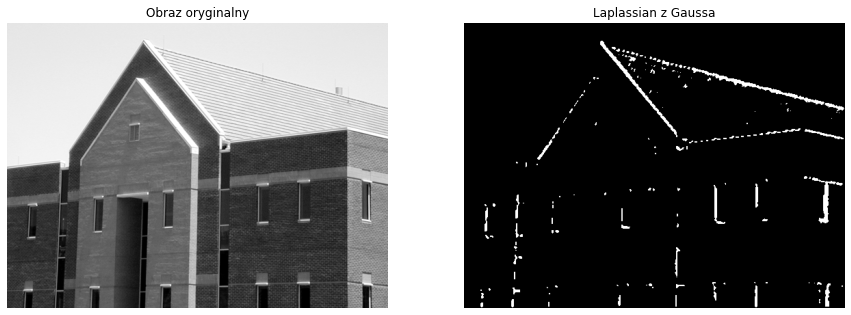

In [21]:
if not os.path.exists("dom.png") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/09_Canny/dom.png --no-check-certificate

house = cv2.imread('dom.png',0)
house_gausse = cv2.GaussianBlur(house, (3,3), 0)
house_LoG = cv2.Laplacian(house_gausse, cv2.CV_32F)


crossed_img = crossing(house_LoG, 97)

figHist, axsHist = plt.subplots(1, 2)

figHist.set_size_inches(15, 10)
axsHist[0].imshow(house, 'gray')
axsHist[0].axis('off')
axsHist[0].set_title('Obraz oryginalny',)

axsHist[1].imshow(crossed_img, 'gray')
axsHist[1].axis('off')
axsHist[1].set_title('Laplassian z Gaussa')

plt.plot()

## Algorytm Canny'ego

> Algorytm Canny'ego to często wykorzystywana metoda detekcji krawędzi.
> Zaproponowana została w~1986r. przez Johna F. Cannego.
> Przy jego projektowaniu założono trzy cele:
> - niska liczba błędów - algorytm powinien znajdywać wszystkie krawędzie oraz generować jak najmniej fałszywych detekcji,
> - punkty krawędziowe powinny być poprawnie lokalizowane - wykryte punkty powinny być jak najbardziej zbliżone do rzeczywistych,
> - krawędzie o szerokości 1 piksela - algorytm powinien zwrócić jeden punkt dla każdej rzeczywistej krawędzi.

Zaimplementuj pierwszą część algorytmu detekcji krawędzi Canny'ego:
1. W pierwszym kroku obraz przefiltruj dwuwymiarowym filtrem Gaussa.
2. Następnie oblicz gradient pionowy i poziomy ($g_x $ i $g_y$).
Jedną z metod jest filtracja Sobela.
3. Dalej oblicz amplitudę:
$M(x,y)  = \sqrt{g_x^2+g_y^2}$ oraz kąt:
$\alpha(x,y) = arctan(\frac{g_y}{g_x})$.
Do obliczenia kąta wykorzystaj funkcję `np.arctan2(x1, x2)`.
Wynik jest w radianach.
4. W kolejnym etapie wykonaj kwantyzację kątów gradientu.
Kąty od $-180^\circ$ do $180^\circ$ można podzielić na 8 przedziałów:
[$-22.5^\circ, 22.5^\circ$], [$22.5^\circ, 67.5^\circ$],
[$67.5^\circ, 112.5^\circ$], [$112.5^\circ, 157.5^\circ$],
[$157.5^\circ, -157.5^\circ$], [$-157.5^\circ, -112.5^\circ$],
[$-112.5^\circ, -67.5^\circ$], [$-67.5^\circ, -22.5^\circ$].
Przy czym należy rozpatrywać tylko 4 kierunki:
    - pionowy ($d_1$),
    - poziomy ($d_2$),
    - skośny lewy ($d_3$),
    - skośny prawy ($d_4$).
5. Dalej przeprowadź eliminację pikseli, które nie mają wartości maksymalnej (ang. *nonmaximal suppresion*).
Celem tej operacji jest redukcja szerokości krawędzi do rozmiaru 1 piksela.
Algorytm przebiega następująco.
W rozpatrywanym otoczeniu o rozmiarze $3 \times 3$:
    - określ do którego przedziału należy kierunek gradientu piksela centralnego ($d_1, d_2, d_3, d_4$).
    - przeanalizuje sąsiadów leżących na tym kierunku.
Jeśli choć jeden z nich ma amplitudę większą niż piksel centralny, to należy uznać, że nie jest lokalnym maksimum i do wyniku przypisać $g_N(x,y) = 0$.
W przeciwnym przypadku $g_N(x,y) = M(x,y)$.
Przez $g_N$ rozumiemy obraz detekcji lokalnych maksimów.
Zaimplementuj funkcję `nonmax`.
Pierwszym argementem jest macierz kierunków (po kwantyzacji).
Drugim argumentem jest macierz amplitudy.
6. Ostatnią operacją jest binaryzacja obrazu $g_N$.
Stosuje się tutaj tzw. binaryzację z histerezą.
Wykorzystuje się w niej dwa progi: $T_L$ i $T_H$, przy czym $T_L < T_H$.
Canny zaproponował, aby stosunek progu wyższego do niższego był jak 3 lub 2 do 1.
Rezultaty binaryzacji można opisać jako:<br>
$g_{NH}(x,y) = g_N(x,y) \geq TH $<br>
$g_{NL}(x,y) = TH > g_N(x,y) \geq TL $<br>
Można powiedzieć, że na obrazie $g_{NH}$ są "pewne" krawędzie.
Natomiast na $g_{NL}$ "potencjalne".
7. Na jednym obrazie zaznacz piksele należące do obrazu $g_{NH}$ jako czerwone oraz należące do obrazu $g_{NL}$ jako niebieskie.
Wyświetl obraz.

In [22]:
# img = cv2.GaussianBlur(house, (5, 5), 1.4)

# gx = cv2.Sobel(np.float32(img), cv2.CV_64F, 1, 0, 3)
# gy = cv2.Sobel(np.float32(img), cv2.CV_64F, 0, 1, 3)

# M = np.sqrt((gx ** 2) + (gy ** 2))
# M = M * 100 / M.max()
# M = np.sqrt(gx**2 + gy**2)

# A = np.rad2deg(np.arctan2(gy, gx)) + 180

# quantized = np.zeros((A.shape[0], A.shape[1]))
# for i in range(A.shape[0]):
#     for j in range(A.shape[1]):
#         if 0 <= A[i, j] <= 22.5 or 157.5 <= A[i, j] <= 202.5 or 337.5 <= A[i, j] <= 360:
#             quantized[i, j] = 0
#         elif 22.5 <= A[i, j] <= 67.5 or 202.5 <= A[i, j] <= 247.5:
#             quantized[i, j] = 1
#         elif 67.5 <= A[i, j] <= 122.5 or 247.5 <= A[i, j] <= 292.5:
#             quantized[i, j] = 2
#         elif 112.5 <= A[i, j] <= 157.5 or 292.5 <= A[i, j] <= 337.5:
#             quantized[i, j] = 3

# magni = np.zeros(quantized.shape)
# a,b = np.shape(quantized)
# for i in range(a-1):
#     for j in range(b-1):
#         if quantized[i,j] == 0:
#             if  magni[i,j-1]< magni[i,j] or magni[i,j] > magni[i,j+1]:
#                 M[i,j] = D[i,j]
#             else:
#                 M[i,j] = 0
#         if quantized[i,j]==1:
#             if  magni[i-1,j+1]<= magni[i,j] or magni[i,j] >= magni[i+1,j-1]:
#                 M[i,j] = D[i,j]
#             else:
#                 M[i,j] = 0       
#         if quantized[i,j] == 2:
#             if  magni[i-1,j]<= magni[i,j] or magni[i,j] >= magni[i+1,j]:
#                 M[i,j] = D[i,j]
#             else:
#                 M[i,j] = 0
#         if quantized[i,j] == 3:
#             if  magni[i-1,j-1]<= magni[i,j] or magni[i,j] >= magni[i+1,j+1]:
#                 M[i,j] = D[i,j]
#             else:
#                 M[i,j] = 0

In [23]:
from scipy import ndimage
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib.image as mpimg
import os
import scipy.misc as sm



def fgaussian(size = 5, sigma = 0.5):
    s = size//2
    x, y = np.mgrid[-s:s+1, -s:s+1]
    norm = 1 / (2.0 * np.pi * sigma**2)
    g = np.exp(-(x**2 + y**2)/(2*sigma**2)*norm)
    return g

def convolution(img, size = 5, sigma = 0.5):
    IConv = img.copy()
    n  = size//2
    (X_size, Y_size) = img.shape
    for x in range (n, X_size - n):
        for y in range (n, Y_size - n):
            frame = img[x-n : x+n+1, y - n : y+n+1]
            IConv[x, y] = new_pixel(frame, size, sigma)
    return IConv

def new_pixel(frame, size = 5, sigma = 0.5):
    mask = fgaussian(size, sigma)
    W = 1/(np.sum(mask))
    Y = mask * frame
    out = W * np.sum(Y)
    return np.uint8(out)


def quant_angle(theta):
    d1 = 0
    d2 = 1
    d3 = 2
    d4 = 3
    xSize, ySize = theta.shape
    quantized = np.zeros((xSize, ySize))
    for i in range(xSize):
        for j in range(ySize):
            if 0 <= theta[i, j] <= 22.5 or 157.5 <= theta[i, j] <= 180:
                quantized[i, j] = d1
            elif 22.5 <= theta[i, j] <= 67.5:
                quantized[i, j] = d2
            elif 67.5 <= theta[i, j] <= 122.5:
                quantized[i, j] = d3
            elif 112.5 <= theta[i, j] <= 157.5:
                quantized[i, j] = d4
    return quantized
    
    
def nonmax(quant, magni):
    nms = np.zeros(quant.shape)
    a, b = np.shape(quant)
    for i in range(a-1):
        for j in range(b-1):
            if quant[i,j] == 0:
                if  magni[i,j-1]< magni[i,j] or magni[i,j] > magni[i,j+1]:
                    nms[i,j] = magni[i,j]
                else:
                    nms[i,j] = 0
            if quant[i,j] == 1:
                if  magnii[i-1,j+1]<= magni[i,j] or magni[i,j] >= magni[i+1,j-1]:
                    nms[i,j] = magni[i,j]
                else:
                    nms[i,j] = 0       
            if quant[i,j] == 2:
                if  magni[i-1,j]<= magni[i,j] or magni[i,j] >= magni[i+1,j]:
                    nms[i,j] = magni[i,j]
                else:
                    nms[i,j] = 0
            if quant[i,j] == 3:
                if  magni[i-1,j-1]<= magni[i,j] or magni[i,j] >= magni[i+1,j+1]:
                    nms[i,j] = magni[i,j]
                else:
                    nms[i,j] = 0
    return nms


def threshold(img, tLow = 30, tHigh = 60):
    M, N = img.shape

    strong_i, strong_j = np.where(img >= tHigh)
    zeros_i, zeros_j = np.where(img < tLow)
    weak_i, weak_j = np.where((img <= tHigh) & (img >= tLow))
    
    R = np.zeros((M,N))
    R[strong_i, strong_j] = 255
    B = np.zeros((M,N))
    B[weak_i, weak_j] = 255
    
    dim = np.zeros((M,N))
    stacked = np.stack((R, dim, B), axis=2)
    

    return stacked


def Canny_alghoritm(img): 

    img_filtered = convolution(img, 5, 1.5)

    Kx1 = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Kx2 = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    
    x1 = ndimage.filters.convolve(img_filtered, Kx1)
    x2 = ndimage.filters.convolve(img_filtered, Kx2)
    
    magni = np.hypot(x1, x2)
    magni = magni/magni.max()*255
    theta = np.arctan2(x2, x1)
    
    quant_img = quant_angle(theta)
    
    nms = nonmax(quant_img, magni)
    
    img_bin = threshold(nms, tLow = 185, tHigh = 240)

    return img_bin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[]

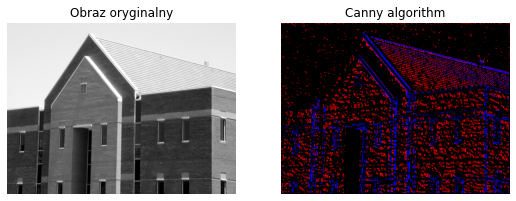

In [24]:
can = Canny_alghoritm(house)



figHist, axsHist = plt.subplots(1, 2)

figHist.set_size_inches(9, 6)
axsHist[0].imshow(house, 'gray')
axsHist[0].axis('off')
axsHist[0].set_title('Obraz oryginalny',)

axsHist[1].imshow(can)
axsHist[1].axis('off')
axsHist[1].set_title('Canny algorithm')

plt.plot()


## Algorytm Canny'ego - OpenCV

1. Wykonaj dektekcję krawędzi metodą Canny'ego wykorzystując funkcję `cv2.Canny`.
    - Pierwszym argumentem funkcji jest obraz wejściowy.
    - Drugim argumentem jest mniejszy próg.
    - Trzecim argumentem jest większy próg.
    - Czwarty argument to tablica, do której wpisany zostanie wynik.
    Można zwrócić go przez wartość i podać wartość `None`.
    - Piąty argument to rozmiar operatora Sobela (w naszym przypadku 3).
    - Szósty argument to rodzaj używanej normy.
    0 oznacza normę $L_1$, 1 oznacza normę $L_2$. Użyj $L_2$.
2. Wynik wyświetl i porównaj z wykonaną częściową implementacją w poprzednim ćwiczeniu.
Na czym polegają różnice?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[]

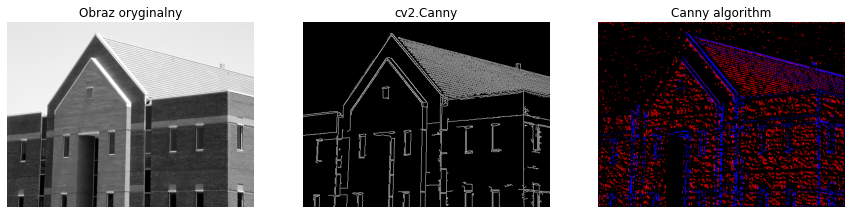

In [25]:
final = cv2.Canny(house, 90, 215, None, 3, 1)

figHist, axsHist = plt.subplots(1, 3)

figHist.set_size_inches(15, 10)
axsHist[0].imshow(house, 'gray')
axsHist[0].axis('off')
axsHist[0].set_title('Obraz oryginalny',)

axsHist[1].imshow(final, 'gray')
axsHist[1].axis('off')
axsHist[1].set_title('cv2.Canny')

axsHist[2].imshow(can)
axsHist[2].axis('off')
axsHist[2].set_title('Canny algorithm')
plt.plot()

Funkcja Canny z biblioteki cv2 pozwala na przecyzyjne wyznaczenie krawędzi na obrazie. Natomiast częściowa implementacja algorytmu Canny-ego pozwala wyznaczyć więcej krawędzi domu chociaż jest mocno zaszumiona.